# FIG CESM run evaluations

In [1]:
import os
import sys
import yaml
import argparse
from glob import glob
from datetime import datetime, timedelta

import numpy as np
import xarray as xr

sys.path.insert(0, os.path.realpath('../libs/'))
import graph_utils as gu
#import verif_utils as vu

In [2]:
import pandas as pd

In [3]:
import matplotlib.dates as mdates

In [4]:
import cmaps
# graph tools
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import matplotlib.colorbar as cbar
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature

%matplotlib inline

In [5]:
import matplotlib.lines as mlines

In [6]:
from matplotlib.colors import Normalize

In [7]:
fig_keys = {
    'dpi': 150, 
    'orientation':'portrait', 
    'bbox_inches':'tight', 
    'pad_inches':0.1, 
    'transparent':False
}

In [8]:
need_publish = False

if need_publish:
    dpi_ = fig_keys['dpi']
else:
    dpi_ = 75

In [9]:
from numpy.lib.stride_tricks import sliding_window_view

def moving_average_axis(a, window, axis=-1, pad_mode="reflect"):
    a = np.asarray(a, dtype=float)
    if window < 1:
        raise ValueError("window must be >= 1")

    # asymmetric split works for even/odd windows
    pad_left  = (window - 1) // 2
    pad_right =  window // 2

    # Build pad widths for all axes; pad only along the chosen axis
    pad_widths = [(0, 0)] * a.ndim
    pad_widths[axis] = (pad_left, pad_right)

    apad = np.pad(a, pad_widths, mode=pad_mode)

    # Sliding windows along `axis`, then average over the last dim (window)
    sw = sliding_window_view(apad, window_shape=window, axis=axis)
    return sw.mean(axis=-1)

## Prep data

In [10]:
fn = '/glade/campaign/ral/hap/ksha/GWC_results/scores/TP/ETS_all.zarr'
ds_ETS = xr.open_zarr(fn)

dict_ETS = {}

for name in ['B3H', 'B6H', 'GDAS']:
    dict_ETS[name] = ds_ETS[name].values

In [11]:
fn = '/glade/campaign/ral/hap/ksha/GWC_results/scores/TP/qq_all.npy'
data_q = np.load(fn,allow_pickle=True)[()]

In [12]:
time_daily = ds_ETS['time'].values

In [13]:
ds = xr.open_zarr('/glade/campaign/ral/hap/ksha/GWC_results/MET/object_verif_all.zarr')

In [14]:
PLOT_MET = {name: da.values for name, da in ds.data_vars.items()}

## Plot

In [15]:
my_colors = gu.ksha_color_set_summon(color_set=0)
cyan = my_colors['cyan']
blue = my_colors['blue']
red = my_colors['red']
orange = my_colors['orange']

In [16]:
line_keys = {}
line_keys['B3H'] = {'linewidth': 3.5, 'linestyle': '--', 'color': blue, 'alpha': 1, 'zorder': 6, 'label': ''}
line_keys['B6H'] = {'linewidth': 3.5, 'linestyle': '--', 'color': red, 'alpha': 1, 'zorder': 7, 'label': ''}
line_keys['GDAS'] = {'linewidth': 3.5, 'linestyle': '-', 'color': orange, 'alpha': 1, 'zorder': 5, 'label': ''}
line_keys['target'] = {'linewidth': 3.5, 'linestyle': '-', 'color': '0.75', 'alpha': 1, 'zorder': 4, 'label': ''}

In [17]:
# LIM_tp = [0, 4]
# cmap_tp = cmaps.perc2_9lev #rh_19lev

In [18]:
line_keys.keys()

dict_keys(['B3H', 'B6H', 'GDAS', 'target'])

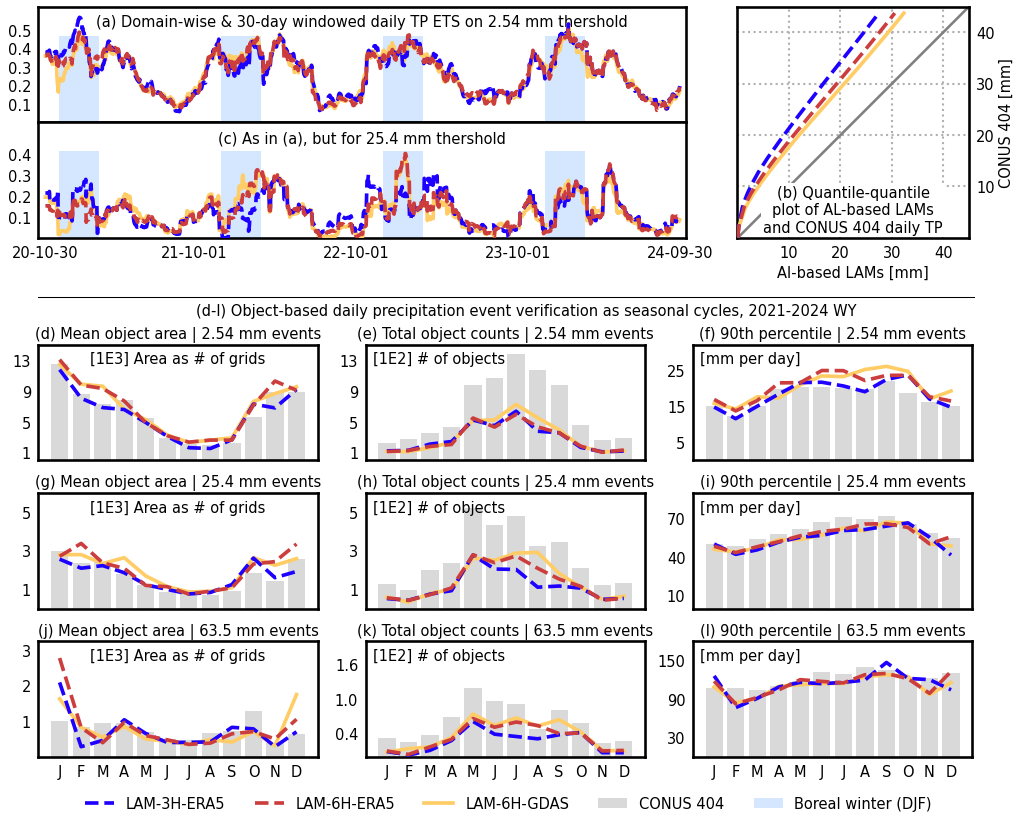

In [19]:
fig = plt.figure(figsize=(13, 10), dpi=dpi_)
gs = gridspec.GridSpec(8, 48, height_ratios=[0.5, 0.5, 0.46, 0.5, 0.14, 0.5, 0.14, 0.5], width_ratios=[1,]*48)

AX_box = []
AX_MET = []
AX_lines = []

AX_lines.append(plt.subplot(gs[0, 0:32]))
AX_lines.append(plt.subplot(gs[1, 0:32]))
AX_box.append(plt.subplot(gs[0:2, 32:48]))

AX_MET.append(plt.subplot(gs[3, 0:14]))
AX_MET.append(plt.subplot(gs[3, 16:30]))
AX_MET.append(plt.subplot(gs[3, 32:46]))

AX_MET.append(plt.subplot(gs[5, 0:14]))
AX_MET.append(plt.subplot(gs[5, 16:30]))
AX_MET.append(plt.subplot(gs[5, 32:46]))

AX_MET.append(plt.subplot(gs[7, 0:14]))
AX_MET.append(plt.subplot(gs[7, 16:30]))
AX_MET.append(plt.subplot(gs[7, 32:46]))

# AX_MET.append(plt.subplot(gs[7, 1:15]))
# AX_MET.append(plt.subplot(gs[7, 17:31]))
# AX_MET.append(plt.subplot(gs[7, 33:47]))

for ax in AX_lines + AX_box + AX_MET:
    ax = gu.ax_decorate_box(ax)

for ax in AX_MET:
    ax.tick_params(labelleft=True, labelsize=14)

for ax in AX_MET[-3:]:
    ax.tick_params(labelbottom=True, labelsize=14)
    ax.set_xticks(np.arange(1, 13, 1))
    ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
    
for ax in AX_lines:    
    ax.tick_params(labelleft=True, labelsize=14)
    
    ax.axvspan(
        np.datetime64('2020-12-01T00'),
        np.datetime64('2021-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.75, zorder=1)

    ax.axvspan(
        np.datetime64('2021-12-01T00'),
        np.datetime64('2022-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.75, zorder=1)

    ax.axvspan(
        np.datetime64('2022-12-01T00'),
        np.datetime64('2023-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.75, zorder=1)
    
    ax.axvspan(
        np.datetime64('2023-12-01T00'),
        np.datetime64('2024-03-01T00'), 
        color=cyan, linewidth=0, alpha=0.25, ymin=0, ymax=0.75, zorder=1)
    
    ax.set_xlim([np.datetime64('2020-10-15'), np.datetime64('2024-10-14')])

X_TICKS = np.array([
    np.datetime64('2020-10-30'),
    np.datetime64('2021-10-01'), 
    np.datetime64('2022-10-01'), 
    np.datetime64('2023-10-01'), 
    np.datetime64('2024-09-30')])

AX_lines[1].tick_params(labelbottom=True, labelsize=14)
AX_lines[1].set_xticks(X_TICKS)
AX_lines[1].xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d'))

AX_lines[0].set_ylim([0, 0.625])
AX_lines[0].set_yticks([0.1, 0.2, 0.3, 0.4, 0.5])

AX_lines[1].set_ylim([0, 0.55])
AX_lines[1].set_yticks([0.1, 0.2, 0.3, 0.4])

AX_box[0].tick_params(labelbottom=True, labelright=True, labelsize=14)
AX_box[0].set_xticks([10, 20, 30, 40])
AX_box[0].set_yticks([10, 20, 30, 40])
AX_box[0].set_xlabel('AI-based LAMs [mm]', fontsize=14)
AX_box[0].set_ylabel('CONUS 404 [mm]', fontsize=14)
AX_box[0].yaxis.set_label_position("right")
AX_box[0].grid(linestyle=':', lw=2)

plt.subplots_adjust(0, 0, 1, 1, hspace=0.0, wspace=0.5)

ref_x = np.linspace(0, 100, 100)

for name in ['B3H', 'B6H', 'GDAS']:
    AX_lines[0].plot(time_daily, dict_ETS[name][:, 1], **line_keys[name])
    AX_lines[1].plot(time_daily, dict_ETS[name][:, -1], **line_keys[name])
    AX_box[0].plot(data_q[name], data_q['target'], **line_keys[name])
    
AX_box[0].plot(ref_x, ref_x, color='0.5', linewidth=2.5)
AX_box[0].set_aspect('equal', adjustable='box')
AX_box[0].set_xlim([-0.1, 45])
AX_box[0].set_ylim([-0.1, 45])

AX_lines[0].set_title('(a) Domain-wise & 30-day windowed daily TP ETS on 2.54 mm thershold', fontsize=14, y=0.775)
AX_lines[1].set_title('(c) As in (a), but for 25.4 mm thershold', fontsize=14, y=0.775)

AX_box[0].set_title(
    '(b) Quantile-quantile\nplot of AL-based LAMs\nand CONUS 404 daily TP', 
    fontsize=14, y=0., bbox=dict(facecolor='white', edgecolor='none', pad=2), zorder=3)

handle_legneds1 = []
handle_legneds1.append(mlines.Line2D([], [], **line_keys['B3H']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['B6H']))
handle_legneds1.append(mlines.Line2D([], [], **line_keys['GDAS']))
handle_legneds1.append(patches.Patch(facecolor='0.85', label=' '))
handle_legneds1.append(patches.Patch(facecolor=cyan, alpha=0.25, label=' '))

ax_lg1 = fig.add_axes([0.5*(1-0.86), -0.085, 0.86, 0.05])
LG1 = ax_lg1.legend(
    handle_legneds1, 
    ['LAM-3H-ERA5', 'LAM-6H-ERA5', 'LAM-6H-GDAS', 'CONUS 404', 'Boreal winter (DJF)'], 
    bbox_to_anchor=(1, 1), ncol=5, prop={'size':14}
)

# =========================================================== #
N_thres = 3
N_vars = 3

months = np.arange(1, 13, 1)

metric_names = ["mean_object_area", "total_objects", "mean_intensity90"]
exp_names = ["B3H", "B6H", "GDAS", "target"]
# N_exp = 4
f_scale = [1e-3, 1e-2, 1]

# axis formatting
axis_specs = {
    0: ((0, 15),  [1, 5, 9, 13]),
    1: ((0, 15),  [1, 5, 9, 13]),
    2: ((0, 32),  [5, 15, 25]),
    3: ((0, 6),   [1, 3, 5]),
    4: ((0, 6),   [1, 3, 5]),
    5: ((0, 90),  [10, 40, 70]),
    6: ((0, 3.25),   [1, 2, 3]),
    7: ((0, 2),   [0.4, 1, 1.6]),
    8: ((0, 180), [30, 90, 150]),
}

col_text = {
    0: dict(x=0.5,   y=0.94, s="[1E3] Area as # of grids", fontsize=14, ha="center", va="top"),
    1: dict(x=0.025, y=0.94, s="[1E2] # of objects",       fontsize=14, ha="left",   va="top"),
    2: dict(x=0.025, y=0.94, s="[mm per day]",             fontsize=14, ha="left",   va="top"),
}

# Titles: row (threshold) x col (metric)
titles = [
    ["(d) Mean object area | 2.54 mm events",
     "(e) Total object counts | 2.54 mm events",
     "(f) 90th percentile | 2.54 mm events"],
    ["(g) Mean object area | 25.4 mm events",
     "(h) Total object counts | 25.4 mm events",
     "(i) 90th percentile | 25.4 mm events"],
    ["(j) Mean object area | 63.5 mm events",
     "(k) Total object counts | 63.5 mm events",
     "(l) 90th percentile | 63.5 mm events"],
]

for col, metric in enumerate(metric_names):
    scale = f_scale[col]
    data_ = PLOT_MET[metric]

    for thr in range(N_thres):
        ax_idx = col + thr * N_vars

        for exp_i, exp in enumerate(exp_names):
            series = scale * data_[N_thres * exp_i + thr]

            if exp == "target":
                AX_MET[ax_idx].bar(months, series, color="0.85")
            else:
                AX_MET[ax_idx].plot(months, series, **line_keys[exp])

for ax_idx, (ylim, yticks) in axis_specs.items():
    AX_MET[ax_idx].set_ylim(list(ylim))
    AX_MET[ax_idx].set_yticks(yticks)

for thr in range(N_thres):
    base = thr * N_vars
    for col in range(N_vars):
        kw = col_text[col]
        AX_MET[base + col].text(
            kw["x"], kw["y"], kw["s"],
            fontsize=kw["fontsize"],
            ha=kw["ha"], va=kw["va"],
            transform=AX_MET[base + col].transAxes,
        )

# ======================================================= #
# titles
for thr in range(N_thres):
    for col in range(N_vars):
        AX_MET[col + thr * N_vars].set_title(titles[thr][col], fontsize=14)

ax_title1 = fig.add_axes([0.0, 0.575, 1.0, 0.04])

ax_title1.text(
    0.5, 0.5, 
    '(d-l) Object-based daily precipitation event verification as seasonal cycles, 2021-2024 WY', 
    fontsize=14, va='center', ha='center', transform=ax_title1.transAxes
)

ax_title1.axhline(y=0.95, xmin=0, xmax=0.96, lw=1, ls='-', color='k')

ax_title1.set_axis_off()
ax_lg1.set_axis_off()
LG1 = gu.lg_box(LG1)